In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pickle
import statsmodels.api as sm
import seaborn as sns
from collections import Counter
import scipy.stats as st
from scipy.stats import gaussian_kde

plt.style.use('default')
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = 'bold'

In [2]:
os.getcwd()

'/sc/arion/projects/MetaDope/Randy/ehr'

In [3]:
os.chdir('MSDW1794_V3/code/')

In [6]:
#OUD

#import data for the different enrollment periods
path = '../voe_outputs/opioids/controlsLessThan3Opioids/binary_exposure/binary_outcome/controlVarOUD/analyses/period_summaries/'
# path = '../voe_outputs/aud/controlsNoAUDDX/binary_outcome/controlVarOUD/analyses/'

datasets = []
for enrollment_year in range(1989,2020):
    if os.path.exists(path + f'voe_{enrollment_year}_{enrollment_year+3}.csv'):
        ds = pd.read_csv(path + f'voe_{enrollment_year}_{enrollment_year+3}.csv')
        datasets.append(ds)
allexpts = pd.concat(datasets)
print(allexpts.shape)

#check for duplicate experiments
allexpts = allexpts.drop_duplicates()
print(allexpts.shape)

'''
Based on the DAG, we are making the following changes:
1. Hepatitis C will not be controlled for (no path to or from opioid prescriptions)
2. History of medication-assisted therapy will not be controlled for (creates cycle in DAG)
'''


#remove 2006-2007; low sample sizes
print(allexpts.shape)
allexpts = allexpts[(allexpts.start_enroll>=2008) & 
            (allexpts['hx_MAT']==0)
            ]
# allexpts = allexpts[~((allexpts['hx_sud_covar']==1) & (allexpts['hx_aud']==1))]
print(allexpts.shape)

# remove crazy confidence interval results
# allexpts = allexpts[(allexpts['.025'] > -5000) & (allexpts['.975'] < 5000)]

#add corrected p-values, OR confidence intervals, percentage of each group with NCD
if 'age_onset_ncd' not in path:
    allexpts['coef'] = np.exp(allexpts['coef'])
    allexpts['.025'] = np.exp(allexpts['.025'])
    allexpts['.975'] = np.exp(allexpts['.975'])


allexpts['bonferroni'] = sm.stats.multipletests(allexpts['p'], alpha=0.05, method='bonferroni')[1]
allexpts['bh_p'] = sm.stats.multipletests(allexpts['p'], alpha=0.05, method='fdr_bh')[1]
allexpts['total_N'] = allexpts['control_N'] + allexpts['opioid_N']
allexpts['opi_percent_ncd'] = 100 * (allexpts['num_opioid_ncd'] / allexpts['opioid_N'])
allexpts['con_percent_ncd'] = 100 * (allexpts['num_control_ncd'] / allexpts['control_N'])

# percentage of sex for total sample
allexpts['total_female%'] = ((allexpts['control_female%'] * allexpts['control_N']) + (allexpts['opioid_female%'] * allexpts['opioid_N'])) / allexpts['total_N']

# mean age for total sample
allexpts['total_mean_age'] = ((allexpts['control_AgeMean'] * allexpts['control_N']) + (allexpts['opioid_AgeMean'] * allexpts['opioid_N'])) / allexpts['total_N']

df = allexpts.copy()


(5184, 28)
(5184, 28)
(5184, 28)
(2592, 28)


In [14]:
df.columns

Index(['control_N', 'opioid_N', 'control_AgeMean', 'control_AgeSD',
       'opioid_AgeMean', 'opioid_AgeSD', 'control_male%', 'control_female%',
       'opioid_male%', 'opioid_female%', 'coef', 'stderr', '.025', '.975', 'p',
       'num_control_ncd', 'num_opioid_ncd', 'followup_time', 'start_enroll',
       'end_enroll', 'opioid_rx_enroll', 'ncd_age_threshold', 'hx_sickle',
       'hx_hiv', 'hx_aud', 'hx_tobacco', 'hx_sud_covar', 'hx_MAT',
       'bonferroni', 'bh_p', 'total_N', 'opi_percent_ncd', 'con_percent_ncd',
       'total_female%', 'total_mean_age'],
      dtype='object')

In [16]:
df[df.total_N==max(df.total_N)].loc[:,['start_enroll', 'ncd_age_threshold', 'opioid_rx_enroll']]

,start_enroll,ncd_age_threshold,opioid_rx_enroll
0,2014,45,5
2,2014,45,5
4,2014,45,5
6,2014,45,5
8,2014,45,5
10,2014,45,5
12,2014,45,5
14,2014,45,5
16,2014,45,5
18,2014,45,5


In [18]:
#AUD

#import data for the different enrollment periods
path = '../voe_outputs/aud/controlsNoAUDDX/binary_outcome/controlVarOUD/analyses/period_summaries/'

datasets = []
for enrollment_year in range(1989,2020):
    if os.path.exists(path + f'voe_{enrollment_year}_{enrollment_year+3}.csv'):
        ds = pd.read_csv(path + f'voe_{enrollment_year}_{enrollment_year+3}.csv')
        datasets.append(ds)
allexpts = pd.concat(datasets)
print(allexpts.shape)

#check for duplicate experiments
allexpts = allexpts.drop_duplicates()
print(allexpts.shape)

'''
Based on the DAG, we are making the following changes:
1. Hepatitis C will not be controlled for (no path to or from opioid prescriptions)
2. History of medication-assisted therapy will not be controlled for (creates cycle in DAG)
'''

#remove 2006-2007; low sample sizes
print(allexpts.shape)
allexpts = allexpts[(allexpts.start_enroll>=2008) ]
print(allexpts.shape)

# remove crazy confidence interval results
# allexpts = allexpts[(allexpts['.025'] > -5000) & (allexpts['.975'] < 5000)]

#add corrected p-values, OR confidence intervals, percentage of each group with NCD
if 'age_onset_ncd' not in path:
    allexpts['coef'] = np.exp(allexpts['coef'])
    allexpts['.025'] = np.exp(allexpts['.025'])
    allexpts['.975'] = np.exp(allexpts['.975'])
allexpts['bonferroni'] = sm.stats.multipletests(allexpts['p'], alpha=0.05, method='bonferroni')[1]
allexpts['bh_p'] = sm.stats.multipletests(allexpts['p'], alpha=0.05, method='fdr_bh')[1]
allexpts['total_N'] = allexpts['control_N'] + allexpts['opioid_N']
allexpts['opi_percent_ncd'] = 100 * (allexpts['num_opioid_ncd'] / allexpts['opioid_N'])
allexpts['con_percent_ncd'] = 100 * (allexpts['num_control_ncd'] / allexpts['control_N'])

df = allexpts.copy()


(156, 23)
(156, 23)
(156, 23)
(108, 23)


NoCon 3.3532 2.5285 4.4579 SUD 3.0899 Smoking 2.886 SUD_Smok 2.7266


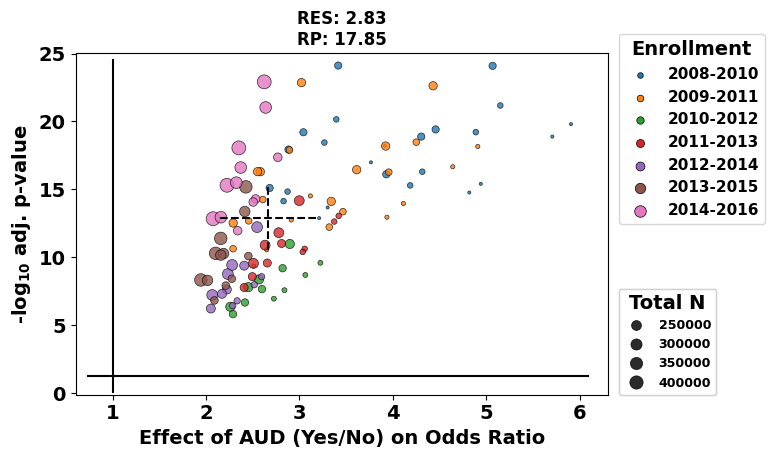

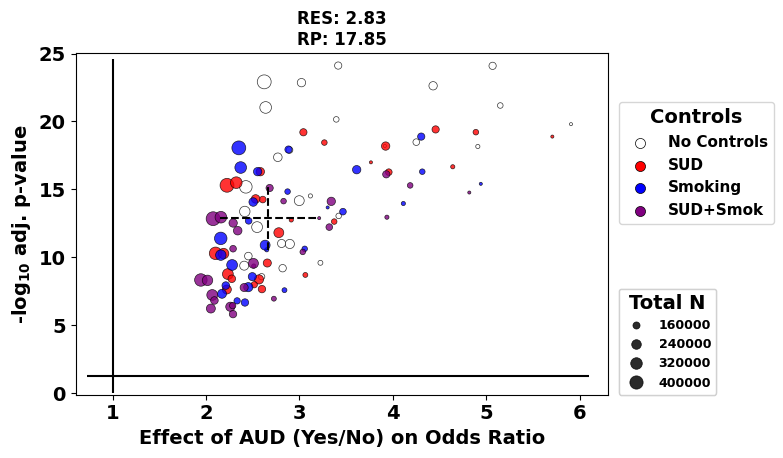

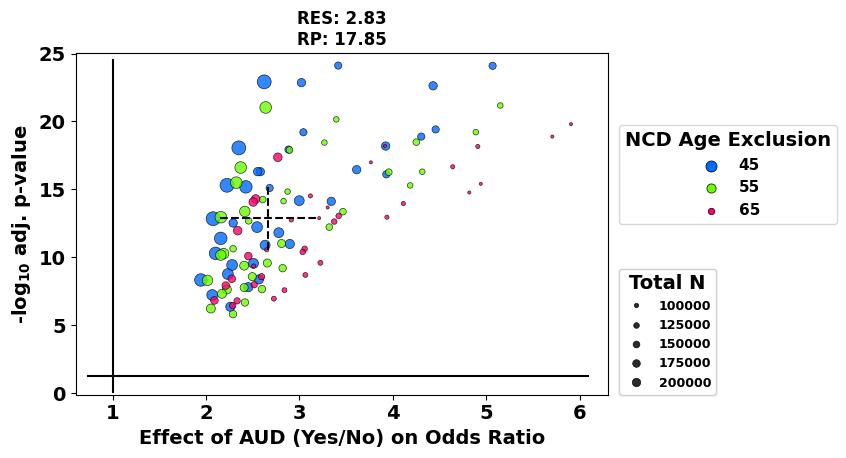

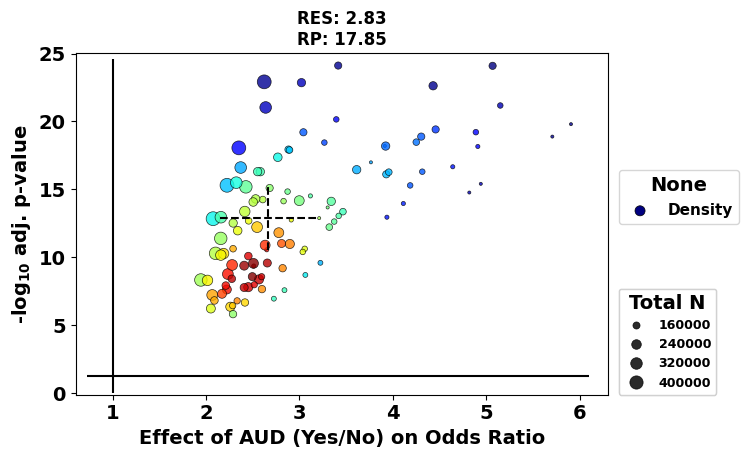

In [19]:
final_plot(df)

In [6]:
def summ_stats(coefs, pvals):
    '''Summary statistics:
    including the 1st, 50th (median), and 99th percentile of effect size and p-values
    the “relative odds ratio” (Rcoef) as the ratio of the 99th and 1st percentile odds ratio
    the “relative p-value” (RP) as the difference between the 99th and 1st percentile of -log10(adjusted p-value). '''

    #calculate relative effect size
    coefs = sorted(abs(coefs))
    rcoef = round(coefs[int(len(coefs)*.99)] / coefs[int(len(coefs)*.01)],2)
    
    #calculate relative p-value    
    ps = sorted(pvals)
    rp = round(ps[int(len(ps)*.99)] - ps[int(len(ps)*.01)],2)

    return rcoef, rp

def marker_scale(df):
    #min-max scale marker size based on total N of experiments for plotting and legend
    markermin = 5
    markermax = 100
    df['markerscale'] = (markermax-markermin) * ((df['total_N'] - min(df['total_N'])) / \
                                                   (max(df['total_N']) - min(df['total_N']))) + markermin
    df.markerscale = pd.to_numeric(df.markerscale)
    return df,markermin,markermax

def add_legends(df, ax, p1, legend1_label, markermin, markermax):
    #Legend colors/groups
    legend1 = ax.legend(loc=(1.02, 0.5), title=legend1_label, prop={'size': 11})
    for lh in legend1.legendHandles: 
        lh.set_alpha(1)
    ax.add_artist(legend1)

    #Legend showing sample sizes
    kw = dict(prop="sizes", num=5,  fmt="{x:.0f}",
              func=lambda s: s/(markermax-markermin) * (\
                                                      (max(df['total_N']) - min(df['total_N']))\
                                                    ) - markermin + min(df['total_N']))
    legend2 = ax.legend(*p1.legend_elements(**kw),#handles, labels,
                               loc=(1.02, 0), title="Total N", prop={'size': 9})
    ax.add_artist(legend2)
    
    
def axis_lines_labels(coefs, pvals, pcol, xlab):
    
    #vertical dotted line showing median coef
    range_pvals = max(pvals) - min(pvals)
    plt.vlines(np.median(coefs), ymin=\
                     np.median(pvals)-(0.13*range_pvals), #np.median(-np.log10(r[p_col]))-7,#
               ymax=\
                     np.median(pvals)+(0.13*range_pvals), #np.median(-np.log10(r[p_col]))+7,#
                     linestyles='dashed', color='k')
    
    #horizontal dotted line showing median p-value  
    range_coefs = (max(coefs) - min(coefs))
    plt.hlines(np.median(pvals), xmin=\
                     np.median(coefs)-(0.13*range_coefs), #np.median(r.coef)-2,#
               xmax=\
                     np.median(coefs)+(0.13*range_coefs), #np.median(r.coef)+2,#
                     linestyles='dashed', color='k')  
    
    #axis labels
    plt.ylabel('-log$_{10}$ adj. p-value', fontsize=14)
    plt.xlabel(xlab, fontsize=14)
    
    #mins for axis limits and axis lines
    coef_range = max(coefs) - min(coefs)
    xlim_xmin = min(coefs)-0.1*coef_range
    xlim_xmax = max(coefs)+0.1*coef_range
    hlines_xmin = min(coefs)-0.05*coef_range
    hlines_xmax = max(coefs)+0.05*coef_range
        
    #axis lines
    #if plotting odds ratios (binary outcome)
    if 'age_onset_ncd' not in path:
        if max(coefs) < 1:
            xlim_xmax = 1 + (0.1*coef_range)
            plt.hlines(y=-np.log10(0.05),xmin=hlines_xmin, xmax=1 + (0.07*coef_range), color='black')
        elif min(coefs) > 1:
            xlim_xmin = 1 - (0.1*coef_range)
            plt.hlines(y=-np.log10(0.05),xmin=1 - (0.07*coef_range), xmax=hlines_xmax, color='black')
        else:
            plt.hlines(y=-np.log10(0.05),xmin=hlines_xmin, xmax=hlines_xmax, color='black')
        plt.vlines(1, ymin=0, ymax=max(pvals)+0.5, color='black')

    #if plotting betas (age onset outcome)
    elif 'age_onset_ncd' in path:
        if max(coefs) < 0:
            xlim_xmax = 0 + (0.1*coef_range)
            plt.hlines(y=-np.log10(0.05),xmin=hlines_xmin, xmax=0 + (0.07*coef_range), color='black')
        elif min(coefs) > 0:
            xlim_xmin = 0 - (0.1*coef_range)
            plt.hlines(y=-np.log10(0.05),xmin=0 - (0.07*coef_range), xmax=hlines_xmax, color='black')
        else:
            plt.hlines(y=-np.log10(0.05),xmin=hlines_xmin, xmax=hlines_xmax, color='black')
        plt.vlines(0, ymin=0, ymax=max(pvals)+0.5, color='black')
    
    
    #axis limits
    plt.xlim((xlim_xmin, xlim_xmax))
    plt.ylim((-0.1,max(pvals)+0.05*range_pvals))

def add_title():
    #title
    res,rp = summ_stats(df.coef, -np.log10(df.bh_p))
    plt.title(f"RES: {res}\nRP: {rp}", size=12)
    
def formatting(df, pcol, ax, p1, legend1title, markermin, markermax, xlab):
    #axis lines for significance and division of increased/decreased risk
    axis_lines_labels(df.coef, -np.log10(df[pcol]), pcol, xlab)
    add_legends(df, ax, p1, legend1title, markermin, markermax)
    add_title()

def plot_by_controls(df,pcol,legend1title, xlab, alpha):
    df,markermin,markermax = marker_scale(df)
    
    nocon = df[(df.hx_aud==0) & (df.hx_sud_covar==0) & (df.hx_tobacco==0)]

    aud = df[(df.hx_aud==1) & (df.hx_sud_covar==0) & (df.hx_tobacco==0)]
    sud = df[(df.hx_aud==0) & (df.hx_sud_covar==1) & (df.hx_tobacco==0)]
    tobacco = df[(df.hx_aud==0) & (df.hx_sud_covar==0) & (df.hx_tobacco==1)]
    
    aud_sud = df[(df.hx_aud==1) & (df.hx_sud_covar==1) & (df.hx_tobacco==0)]
    aud_tobacco = df[(df.hx_aud==1) & (df.hx_sud_covar==0) & (df.hx_tobacco==1)]
    sud_tobacco = df[(df.hx_aud==0) & (df.hx_sud_covar==1) & (df.hx_tobacco==1)]
    aud_sud_tobacco = df[(df.hx_aud==1) & (df.hx_sud_covar==1) & (df.hx_tobacco==1)]

    print(df.shape)
    print(nocon.shape[0]+aud.shape[0]+sud.shape[0]+tobacco.shape[0]+aud_sud.shape[0]+aud_tobacco.shape[0]+\
          sud_tobacco.shape[0]+aud_sud_tobacco.shape[0])
#     print(nocon.shape[0]+sud.shape[0])
    print('NoCon', round(np.mean(nocon.coef),4), round(np.mean(nocon['.025']),4), round(np.mean(nocon['.975']),4), 
          'AUD', round(np.mean(aud.coef),4), 
          'SUD', round(np.mean(sud.coef),4), 
          'Smoking', round(np.mean(tobacco.coef),4), 
          'AUD_SUD', round(np.mean(aud_sud.coef),4),
         'AUD_Smok', round(np.mean(aud_tobacco.coef),4), 
          'SUD_Smok', round(np.mean(sud_tobacco.coef),4), 
          'All', round(np.mean(aud_sud_tobacco.coef),4)
                      )
    
    fig, ax = plt.subplots()
    for ds,lab,col in zip([nocon, sud, tobacco, aud, sud_tobacco, aud_sud, aud_tobacco, aud_sud_tobacco],
                          ['No Controls','OUD','Smoking','AUD','OUD+Smok','OUD+AUD', 'Smok+AUD',  'All'],
                          ['white',      'red','yellow','blue','orange', 'purple', 'green',  'black']
                         ):
        p1 = ax.scatter(ds.coef, -np.log10(ds[pcol]), alpha=alpha, s=ds['markerscale'].values, 
                        edgecolor='k', linewidth=0.5,label=lab,c=col)
    formatting(df, pcol, ax, p1, legend1title, markermin, markermax, xlab)
    
def aud_plot_by_controls(df, pcol,legend1title, xlab, alpha):
    df,markermin,markermax = marker_scale(df)
    
    nocon = df[(df.hx_sud_covar==0) & (df.hx_tobacco==0)]
    aud = df[(df.hx_sud_covar==0) & (df.hx_tobacco==0)]
    sud = df[(df.hx_sud_covar==1) & (df.hx_tobacco==0)]
    tobacco = df[(df.hx_sud_covar==0) & (df.hx_tobacco==1)]
    
    aud_sud = df[(df.hx_sud_covar==1) & (df.hx_tobacco==0)]
    aud_tobacco = df[(df.hx_sud_covar==0) & (df.hx_tobacco==1)]
    sud_tobacco = df[(df.hx_sud_covar==1) & (df.hx_tobacco==1)]
    aud_sud_tobacco = df[(df.hx_sud_covar==1) & (df.hx_tobacco==1)]

    print('NoCon', round(np.mean(nocon.coef),4), round(np.mean(nocon['.025']),4), round(np.mean(nocon['.975']),4), 
          'SUD', round(np.mean(sud.coef),4), 
          'Smoking', round(np.mean(tobacco.coef),4), 
          'SUD_Smok', round(np.mean(sud_tobacco.coef),4), 
                      )
    
    fig, ax = plt.subplots()
    for ds,lab,col in zip([nocon, sud, tobacco, sud_tobacco,],
                          ['No Controls','SUD','Smoking','SUD+Smok'],
                          ['white',      'red','blue','purple']
                         ):
        p1 = ax.scatter(ds.coef, -np.log10(ds[pcol]), alpha=alpha, s=ds['markerscale'].values, 
                        edgecolor='k', linewidth=0.5,label=lab,c=col)
    formatting(df, pcol, ax, p1, legend1title, markermin, markermax, xlab)
    

def plot_by_opioid_enroll(df,pcol,legend1title, xlab, alpha):
    df,markermin,markermax = marker_scale(df)
    op5 = df[(df.opioid_rx_enroll==5)]
    op10 = df[(df.opioid_rx_enroll==10)]
    op15 = df[(df.opioid_rx_enroll==15)]

    fig, ax = plt.subplots()
    for ds,lab,col in zip([op5, op10, op15],['5 Rx','10 Rx','15 Rx'], ['#00FF59','#FF5900','#5900FF']):
        p1 = ax.scatter(ds.coef, -np.log10(ds[pcol]), alpha=alpha, c=col,
                        edgecolor='k', linewidth=0.5, s=ds['markerscale'].values, label=lab)
        
    formatting(df, pcol, ax, p1, legend1title, markermin, markermax, xlab)
    
def plot_by_ncd_age_exclusion(df,pcol,legend1title, xlab, alpha):
    df,markermin,markermax = marker_scale(df)

    age45 = df[(df.ncd_age_threshold==45)]
    age55 = df[(df.ncd_age_threshold==55)]
    age65 = df[(df.ncd_age_threshold==65)]
    
    fig, ax = plt.subplots()
    for ds,lab,col in zip([age45,age55,age65], ['45','55','65'], ['#0069FF','#69FF00','#FF0069']):
        p1 = ax.scatter(ds.coef, -np.log10(ds[pcol]), alpha=alpha,
                        s=ds['markerscale'].values, edgecolor='k', linewidth=0.5, label=lab, c=col)

    formatting(df, pcol, ax, p1, legend1title, markermin, markermax, xlab)    
    
def plot_by_enroll_year(df,pcol,legend1title, xlab, alpha):
    df,markermin,markermax = marker_scale(df)

    enroll_years = sorted(list(set(df.start_enroll)))
    
    #plot each year's data in a loop
    fig, ax = plt.subplots()
    for ey in enroll_years:
        ey_df = df[(df.start_enroll==ey)]
        p1 = ax.scatter(ey_df.coef, -np.log10(ey_df[pcol]), alpha=alpha,
                        s=[float(x) for x in ey_df['markerscale'].values], edgecolor='k', linewidth=0.5,
                        label=f'{str(ey)}-{str(ey+2)}')
        
    formatting(df, pcol, ax, p1, legend1title, markermin, markermax, xlab)
        
        
def density_plot(df, pcol, legend1title, xlab, alpha):
    
    df,markermin,markermax = marker_scale(df)
    
    # set x,y data
    x = df.coef
    y = -np.log10(df[pcol])

    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    fig, ax = plt.subplots()
    p1 = ax.scatter(x, y, alpha=alpha, c=z, cmap=plt.cm.jet,s=df['markerscale'].values, edgecolor='k', linewidth=0.5,
                        label='Density')
    formatting(df, pcol, ax, p1, legend1title, markermin, markermax, xlab)


def final_plot(df):
    if 'opioids/controlsLessThan3Opioids/prescription_count/binary_outcome/' in path:
        df = df[df.coef>0.99]


    if 'binary_exposure' in path:
        predictor = 'binaryExposure'
        if 'age_onset_ncd' in  path:
            outcome = 'ageOnsetNCD'
            xlab = 'Effect of OPRx (Yes/No) on Age of NCD Onset (Years)'#binary exposure, age of onset

        elif 'binary_outcome' in path:
            outcome = 'oddsratioNCD'
            xlab = 'Effect of OPRx (Yes/No) on Odds Ratio' #binary exposure, binary outcome
            
    elif 'prescription_count' in path:
        predictor = 'prescriptionCount'
        if 'age_onset_ncd' in  path:
            outcome = 'ageOnsetNCD'
            xlab = r'Effect of Individual OPRx on Age of NCD Onset (Years)' #prescription count, age of onset
        elif 'binary_outcome' in path:
            outcome = 'oddsratioNCD'
            xlab = r'Effect of Individual OPRx on Odds Ratio' #prescription count, binary outcome
    else:
        predictor = ''
        if 'binary_outcome' in path:
            outcome = 'oddsratioNCD'
            xlab = 'Effect of AUD (Yes/No) on Odds Ratio'
        elif 'age_onset_ncd' in path:
            outcome = 'ageOnsetNCD'
            xlab = 'Effect of AUD (Yes/No) on Age of NCD Onset (Years)'


    if '/aud/' in path:
        drug = 'AUD'
        alpha = 0.8
    else:
        drug = ''
        alpha = 0.2
        
    pcol = 'bh_p'

    colorby='enrollYear'
    plot_by_enroll_year(df,pcol,'Enrollment', xlab, alpha)
    plt.tight_layout()
    plt.savefig(f'../figures/{drug}{predictor}_{outcome}_colorBy{colorby}.png', bbox_inches='tight', dpi=300)

    colorby='controlVars'
    if '/aud/' not in path:
        plot_by_controls(df,pcol,'Controls',xlab,alpha)
    else:
        aud_plot_by_controls(df,pcol,'Controls',xlab,alpha)
    plt.tight_layout()
    plt.savefig(f'../figures/{drug}{predictor}_{outcome}_colorBy{colorby}.png', bbox_inches='tight', dpi=300)

    if '/aud/' not in path:
        colorby='OPRxEnroll'
        plot_by_opioid_enroll(df,pcol,'OPRx Enrollment', xlab,alpha)
        plt.tight_layout()
        plt.savefig(f'../figures/{drug}{predictor}_{outcome}_colorBy{colorby}.png', bbox_inches='tight', dpi=300)

    colorby='NCDAgeExclusion'
    plot_by_ncd_age_exclusion(df,pcol,'NCD Age Exclusion',xlab,alpha)
    plt.tight_layout()
    plt.savefig(f'../figures/{drug}{predictor}_{outcome}_colorBy{colorby}.png', bbox_inches='tight', dpi=300)

    colorby='Density'
    density_plot(df,pcol,'None',xlab,alpha)
    plt.tight_layout()
    plt.savefig(f'../figures/{drug}{predictor}_{outcome}_colorBy{colorby}.png', bbox_inches='tight', dpi=300)


In [4]:
set(allexpts.start_enroll), set(allexpts.end_enroll), set(allexpts.followup_time)

({2008, 2009, 2010, 2011, 2012, 2013, 2014},
 {2011, 2012, 2013, 2014, 2015, 2016, 2017},
 {5, 10})

In [5]:
enroll_years = sorted(list(set(allexpts.start_enroll)))
for ey in enroll_years:
    print(ey, np.min(allexpts[allexpts.start_enroll==ey]['opioid_N']), 
         np.max(allexpts[allexpts.start_enroll==ey]['opioid_N']),
         np.min(allexpts[allexpts.start_enroll==ey]['control_N']), 
         np.max(allexpts[allexpts.start_enroll==ey]['control_N']),
         np.min(allexpts[allexpts.start_enroll==ey]['total_N']), 
         np.max(allexpts[allexpts.start_enroll==ey]['total_N']))

2008 147 1979 59410 137544 59557 139523
2009 249 3173 73230 167643 73479 170816
2010 377 4808 86172 192859 86549 197667
2011 610 6561 97047 215905 97657 222466
2012 806 7554 113506 249127 114312 256681
2013 942 8560 145968 319785 146910 328345
2014 1164 9636 174391 386566 175555 396202


In [5]:
print(min(allexpts.opioid_N), max(allexpts.opioid_N),
     min(allexpts.control_N), max(allexpts.control_N),
     min(allexpts.total_N), max(allexpts.total_N),)

259 5458 63549 411025 63875 416483


In [6]:
allexpts.columns

Index(['control_N', 'opioid_N', 'control_AgeMean', 'control_AgeSD',
       'opioid_AgeMean', 'opioid_AgeSD', 'control_male%', 'control_female%',
       'opioid_male%', 'opioid_female%', 'coef', 'stderr', '.025', '.975', 'p',
       'num_control_ncd', 'num_opioid_ncd', 'followup_time', 'start_enroll',
       'end_enroll', 'ncd_age_threshold', 'hx_tobacco', 'hx_sud_covar',
       'bonferroni', 'bh_p', 'total_N', 'opi_percent_ncd', 'con_percent_ncd'],
      dtype='object')

In [8]:
ci = st.t.interval(alpha=0.95, df=df.shape[0]-1, loc=np.mean(df.coef), scale=st.sem(df.coef)) 
np.mean(df.coef), ci

(-3.213321506413413, (-3.501609807028327, -2.925033205798499))

In [58]:
print('min_opi ','max_opi ','min_con ','max_con ','min_tot ','max_tot ', 'opi_ncd')

print(
    np.min(allexpts['opioid_N']), '   ',
    np.max(allexpts['opioid_N']),'   ',
    np.min(allexpts['control_N']), '   ',
    np.max(allexpts['control_N']),'   ',
    np.min(allexpts['total_N']), '   ',
    np.max(allexpts['total_N']), '   ',
    np.min(allexpts['num_opioid_ncd']),'\n',
    'control male %', np.min(allexpts['control_male%']),
    np.max(allexpts['control_male%']),'\n',
    'control female %', np.min(allexpts['control_female%']),
    np.max(allexpts['control_female%']),'\n',
    'opioid male %', np.min(allexpts['opioid_male%']),
    np.max(allexpts['opioid_male%']),'\n',
    'opioid female %', np.min(allexpts['opioid_female%']),
    np.max(allexpts['opioid_female%']),'\n',
    'opioid mean age', np.min(allexpts['opioid_AgeMean']),
    np.max(allexpts['opioid_AgeMean']),'\n',
    'control mean age', np.min(allexpts['control_AgeMean']),
    np.max(allexpts['control_AgeMean']),'\n',
         )

min_opi  max_opi  min_con  max_con  min_tot  max_tot  opi_ncd
147     9636     59410     386566     59557     396202     7 
 control male % 0.4262066503520744 0.4492921869127657 
 control female % 0.5506409988725102 0.5737597202030184 
 opioid male % 0.2288135593220339 0.4455026455026455 
 opioid female % 0.5544973544973545 0.7711864406779662 
 opioid mean age 60.95404814004377 76.67231638418079 
 control mean age 64.8957860757285 76.7806261572126 



# Histogram of opioid prescriptions in opioid-exposed population in time common with UKB

In [39]:
pop = pd.read_csv('../voe_outputs/opioids/controlsLessThan3Opioids/binary_exposure/binary_outcome/controlVarOUD/populations/voe_2010_2013_5yearfollowup_5OpioidsEnrollment_45NCDageExclusion_1.csv')

/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [43]:
pop.columns

Index(['Unnamed: 0', 'MRN', 'AGE', 'DOB', 'RACE', 'SEX', 'YOB', 'age', 'label',
       'ncd', 'sickle', 'hiv', 'aud', 'tobacco', 'sud', 'opioid_count', 'MAT'],
      dtype='object')

/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  """


(0.6575762729279283, 6500)

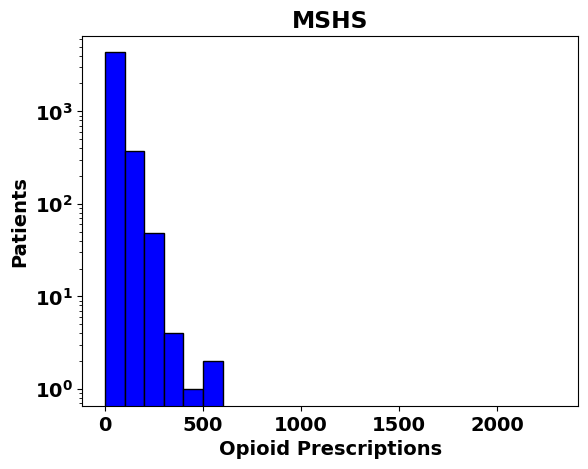

In [55]:
plt.hist(pop[pop.label==1].opioid_count, log=True, color='blue', edgecolor='k', bins=np.arange(0,2400,100))
plt.title('MSHS')
plt.xlabel('Opioid Prescriptions')
plt.ylabel('Patients')
plt.ylim((0,6500))

0.3055555555555556


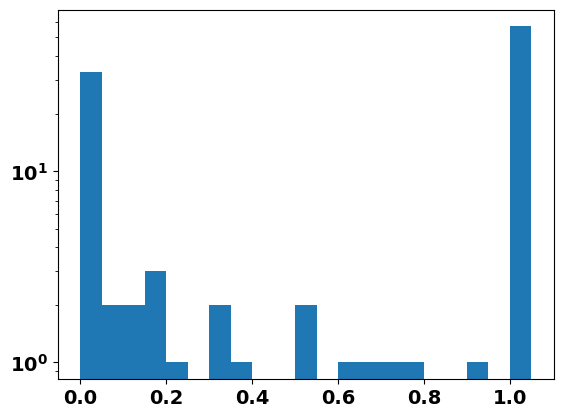

In [11]:
plt.hist(df.bonferroni, bins=np.arange(0,1.1,0.05), log=True)
print(df[df.bonferroni<0.05].shape[0] / df.shape[0])

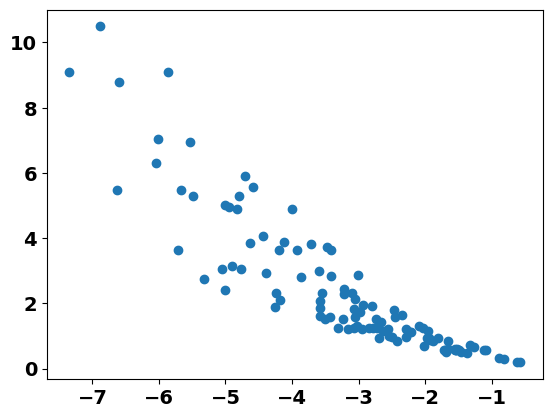

In [12]:
plt.scatter(df.coef, -np.log10(df.bh_p))

In [29]:
nonsig = df[df.bonferroni>=0.05]
sig = df[df.bonferroni<0.05]

# Loop through all individual control variables

In [17]:
def loop_controls(df,controlvars,pcol,legend1title, xlab, alpha):
    df,markermin,markermax = marker_scale(df)
    
    for cv in controlvars:
        cv_df = df[df[cv]==1]
        con_df = df[df[cv]==0]

        fig, ax = plt.subplots()
        for ds,lab,col in zip([cv_df,con_df],
                              [cv, 'No Controls'],
                              ['red', 'blue']
                             ):
            p1 = ax.scatter(ds.coef, -np.log10(ds[pcol]), alpha=alpha, s=ds['markerscale'].values, 
                            edgecolor='k', linewidth=0.5,label=lab,c=col)
        formatting(df, pcol, ax, p1, legend1title, markermin, markermax, xlab)

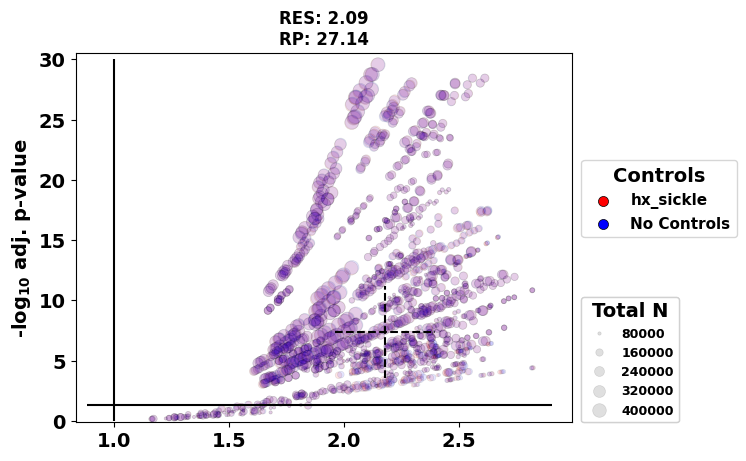

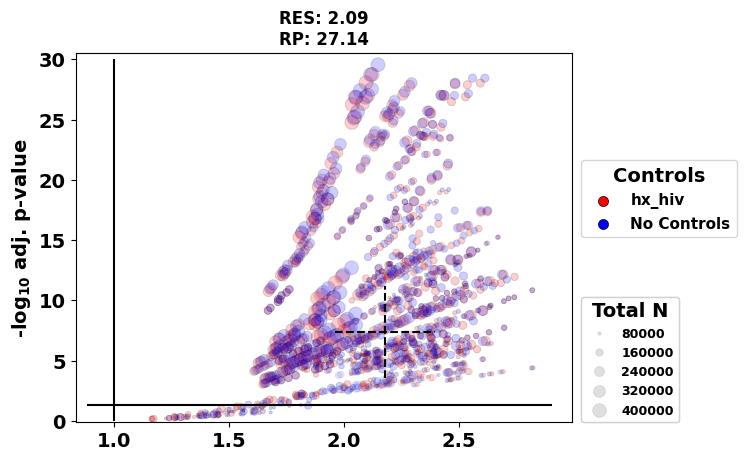

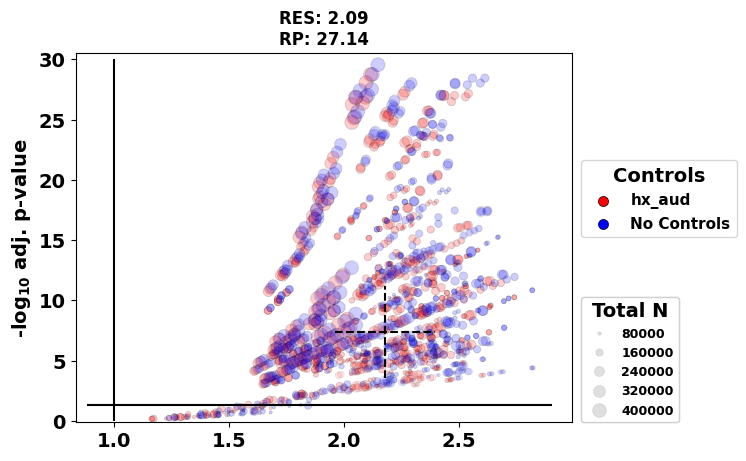

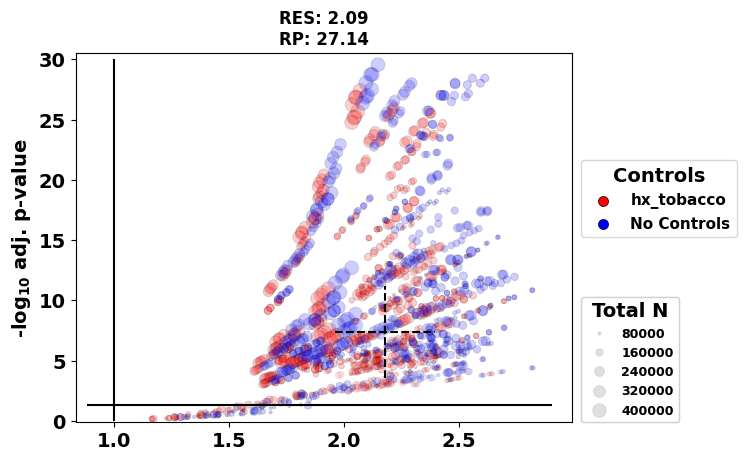

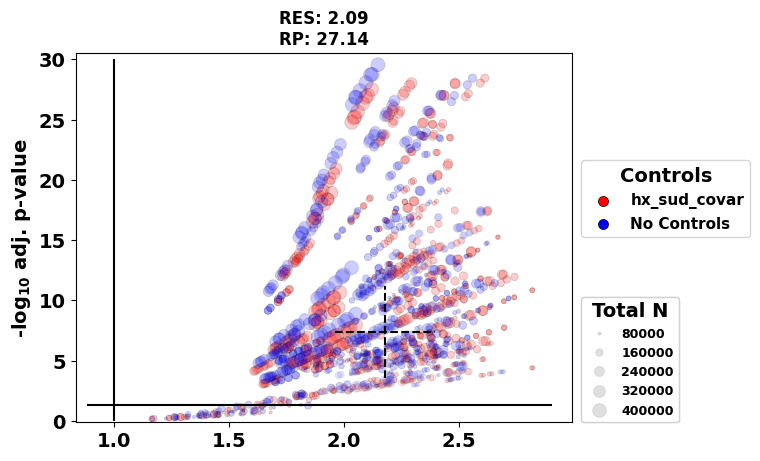

In [18]:
xlab = ''
alpha=0.1
controlvars = ['hx_sickle','hx_hiv', 'hx_aud', 'hx_tobacco', 'hx_sud_covar']

loop_controls(df,controlvars,'bh_p','Controls',xlab,alpha)

In [3]:
df.columns

Index(['control_N', 'opioid_N', 'control_AgeMean', 'control_AgeSD',
       'opioid_AgeMean', 'opioid_AgeSD', 'control_male%', 'control_female%',
       'opioid_male%', 'opioid_female%', 'coef', 'stderr', '.025', '.975', 'p',
       'num_control_ncd', 'num_opioid_ncd', 'followup_time', 'start_enroll',
       'end_enroll', 'opioid_rx_enroll', 'ncd_age_threshold', 'hx_sickle',
       'hx_hiv', 'hx_aud', 'hx_tobacco', 'hx_sud_covar', 'hx_MAT',
       'bonferroni', 'bh_p', 'total_N', 'opi_percent_ncd', 'con_percent_ncd'],
      dtype='object')

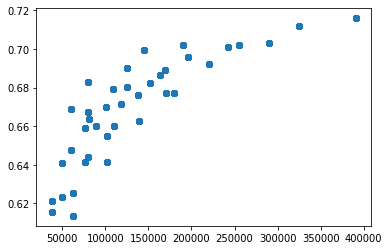

In [60]:
plt.scatter(allexpts['total_N'], allexpts['opioid_male%'])

control_N
opioid_N
control_AgeMean
control_AgeSD
opioid_AgeMean
opioid_AgeSD
control_male%
control_female%
opioid_male%
opioid_female%
coef
stderr
.025
.975
p
num_control_ncd
num_opioid_ncd
followup_time
start_enroll
end_enroll
opioid_rx_enroll
ncd_age_threshold
hx_sickle
hx_hiv
hx_aud
hx_tobacco
hx_sud_covar
hx_MAT
bonferroni
bh_p
total_N
opi_percent_ncd
con_percent_ncd


FloatingPointError: NaN dissimilarity value.

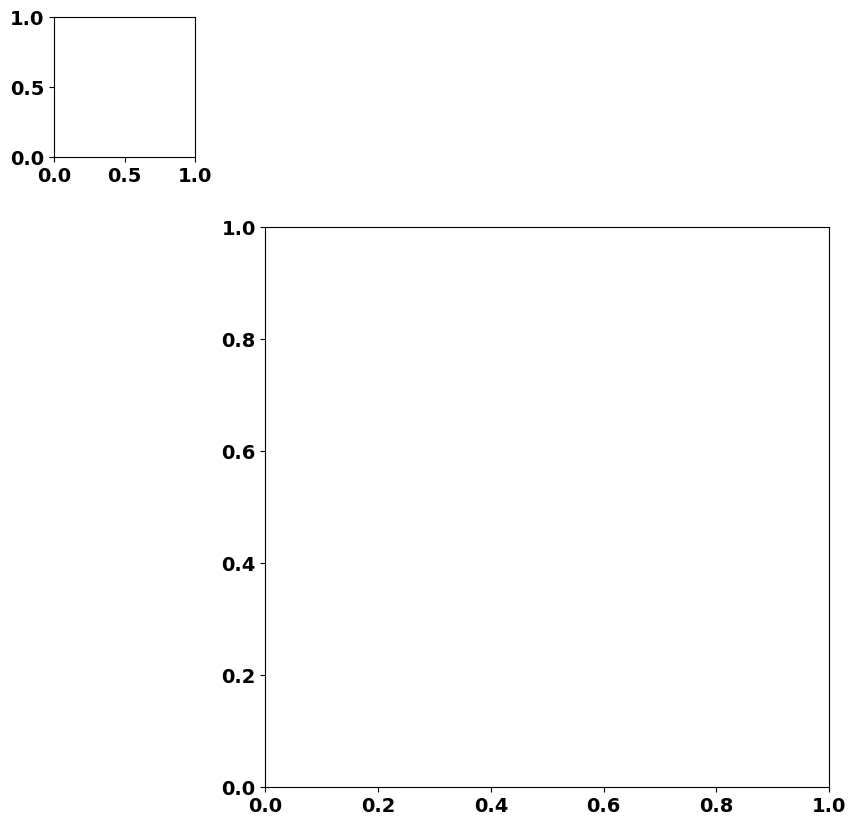

In [32]:
from sklearn.preprocessing import MinMaxScaler


# cols=['OR','p', 'hx_sud_opioid_enroll', 'hx_sickle', 'hx_hepc', 'hx_hiv', 'hx_aud',
#        'hx_sud_covar', 'num_recs_covar']
# sns.heatmap(resy[cols])

resy=allexpts
df = pd.DataFrame()

# scaler = MinMaxScaler()
# df = scaler.fit_transform(resy)
# df = pd.DataFrame(df)
# df.columns = resy.columns


for col in resy.columns: #['OR','p','hx_sud_covar',]:

#[c for c in resy.columns if c not in ['start_enroll', 'end_enroll', 'num_opioid_ncd', 'opi_percent_ncd']]:
    print(col)
    col_zscore = col
    df[col_zscore] = (resy[col] - resy[col].mean())/resy[col].std(ddof=0) #zscore
    #df[col_zscore] = (resy[col] - min(resy[col])/(max(resy[col]) - min(resy[col]))) #minmax
    
df.sort_values('p', inplace=True)
# f, ax = plt.subplots(figsize=(10, 5))
ax = sns.clustermap(df.drop(columns=['start_enroll','end_enroll']), cmap='seismic')
# ax.set_yticks(())


(array([192., 160., 320.,  64., 256.,  96., 160., 128.,  96., 128.,  96.,
         96.,  32.,  64.,   0., 192.,   0.,  96.,  32.,   0.,  64.,   0.,
          0.,   0.,  96.,   0.,   0.,   0.,   0.,  32.,   0.,   0.,   0.,
         64.,   0.,   0.,   0.,  32.,   0.,  32.,   0.,   0.,   0.,   0.,
         32.,   0.,   0.,   0.,   0.,  32.]),
 array([ 147.  ,  336.78,  526.56,  716.34,  906.12, 1095.9 , 1285.68,
        1475.46, 1665.24, 1855.02, 2044.8 , 2234.58, 2424.36, 2614.14,
        2803.92, 2993.7 , 3183.48, 3373.26, 3563.04, 3752.82, 3942.6 ,
        4132.38, 4322.16, 4511.94, 4701.72, 4891.5 , 5081.28, 5271.06,
        5460.84, 5650.62, 5840.4 , 6030.18, 6219.96, 6409.74, 6599.52,
        6789.3 , 6979.08, 7168.86, 7358.64, 7548.42, 7738.2 , 7927.98,
        8117.76, 8307.54, 8497.32, 8687.1 , 8876.88, 9066.66, 9256.44,
        9446.22, 9636.  ]),
 <BarContainer object of 50 artists>)

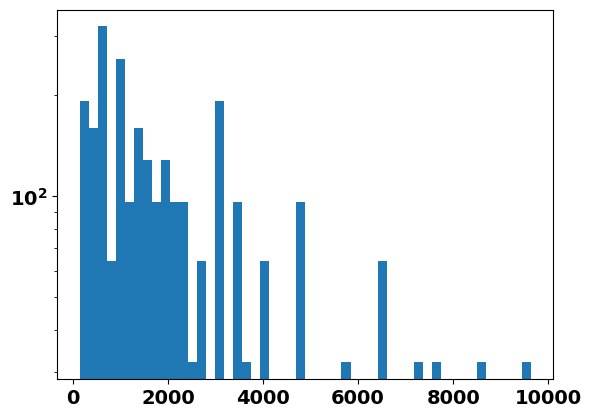

In [34]:
plt.hist(allexpts.opioid_N,bins=50,log=True)

In [35]:
#preprocess data before plotting
res = allexpts.copy()

res = res.sort_values('coef')
res.reset_index(drop=True, inplace=True)



In [54]:
def plot_by_controls(r,panel):
    #plot experiments separately fcoef each set of controls (None, SUD only, AUD only)
    noCon = r[(r['hx_sud_covar']==0) & (r['hx_aud']==0) ]
    conSud = r[(r['hx_sud_covar']==1) & (r['hx_aud']==0)]
    conAud = r[(r['hx_sud_covar']==0) & (r['hx_aud']==1)]
    conDepression = r[(r['hx_sud_covar']==0) & (r['hx_aud']==0) ]
    
    #No controls
    p1 = ax[panel].scatter(noCon.coef, -np.log10(noCon[p_col]), c='#FF0006',
                    s=noCon['markerscale'].values, 
                           edgecolor=edgecolor, cmap=cmap, alpha=alpha,
                    label='Neither'#5
                          )
    #Control AUD only
    p2 = ax[panel].scatter(conAud.coef, -np.log10(conAud[p_col]), c='#0006FF',
                    s=conAud['markerscale'].values, 
                           edgecolor=edgecolor, cmap=cmap, alpha=alpha,
                    label='AUD'#10#
                          )
    #Control SUD only
    p3 = ax[panel].scatter(conSud.coef, -np.log10(conSud[p_col]), c='#06FF00',
                    s=conSud['markerscale'].values, 
                           edgecolor=edgecolor, cmap=cmap, alpha=alpha,
                    label='SUD'#15#
                          )
    
    if panel==(0,6):
        #Legend fcoef colors/groups
        legend1 = ax[panel].legend(loc=(1.02, 0.5), title='Controls', prop={'size': 11})
        ax[panel].add_artist(legend1)
        
        #Legend showing sample sizes
        kw = dict(prop="sizes", num=5,  fmt="{x:.0f}",
                  func=lambda s: s/(markermax-markermin) * (\
                                                          (max(r['total_N']) - min(r['total_N']))\
                                                        ) - markermin + min(r['total_N']))
        legend2 = ax[panel].legend(*p1.legend_elements(**kw),#handles, labels,
                                   loc=(1.02, 0), title="N", prop={'size': 9})
        
    return p1

def plot_by_opioid_rx_enroll(r,panel):
    #plot experiments separately fcoef each opioid exposure criterion (5, 10, coef 15 prescriptions)
    five = r[(r['opioid_rx_enroll']==5)]
    ten = r[(r['opioid_rx_enroll']==10)]  
    fifteen = r[(r['opioid_rx_enroll']==15)]
    
    #5 opioid Rx
    p1 = ax[panel].scatter(five.coef, -np.log10(five[p_col]), c='#FF0006',
                    s=five['markerscale'].values, 
                           edgecolor=edgecolor, cmap=cmap, alpha=alpha,
                    label='5'
                          )
    #10 opioid Rx
    p2 = ax[panel].scatter(ten.coef, -np.log10(ten[p_col]), c='#0006FF',
                    s=ten['markerscale'].values, 
                           edgecolor=edgecolor, cmap=cmap, alpha=alpha,
                    label='10'
                          )
    #15 opioid Rx
    p3 = ax[panel].scatter(fifteen.coef, -np.log10(fifteen[p_col]), c='#06FF00',
                    s=fifteen['markerscale'].values, 
                           edgecolor=edgecolor, cmap=cmap, alpha=alpha,
                    label='15'
                          )
    if panel==(0,6):
        #Legend fcoef colors/groups
        legend1 = ax[panel].legend(loc=(1.02, 0.5), title='Opioid Rx', prop={'size': 11})
        ax[panel].add_artist(legend1)
        
        #Legend showing sample sizes
        kw = dict(prop="sizes", num=5,  fmt="{x:.0f}",
                  func=lambda s: s/(markermax-markermin) * (\
                                                          (max(r['total_N']) - min(r['total_N']))\
                                                        ) - markermin + min(r['total_N']))
        legend2 = ax[panel].legend(*p1.legend_elements(**kw),#handles, labels,
                                   loc=(1.02, 0), title="N", prop={'size': 9})
    
    return p1

In [55]:
def plot_results(r, panel, fu, plotby='controls'):
    
    #solid lines denoting increased/decreased odds and statistical significance
    ax[panel].hlines(-np.log10(0.05),xmin=1-(0.25*max(r.coef)),#0.5,#
                     xmax=max(r['.975']),#8,#
                     color='black')
    ax[panel].vlines(1.0, ymin=-0.5, ymax=-np.log10(min(r[p_col])),#34,#
                     color='black')

    #vertical dotted line showing median coef
    range_pvals = (max(-np.log10(r[p_col])) - min(-np.log10(r[p_col])))
    ax[panel].vlines(np.median(r.coef), ymin=\
                     np.median(-np.log10(r[p_col]))-(0.3*range_pvals), #np.median(-np.log10(r[p_col]))-7,#
               ymax=\
                     np.median(-np.log10(r[p_col]))+(0.3*range_pvals), #np.median(-np.log10(r[p_col]))+7,#
                     linestyles='dashed', color='k')
    
    #horizontal dotted line showing median p-value  
    range_coefs = (max(r['.975']) - min(r['.025']))
    ax[panel].hlines(np.median(-np.log10(r[p_col])), xmin=\
                     np.median(r.coef)-(0.3*range_coefs), #np.median(r.coef)-2,#
               xmax=\
                     np.median(r.coef)+(0.3*range_coefs), #np.median(r.coef)+2,#
                     linestyles='dashed', color='k')    

#     ax[panel].set_xlim((0,8.5))
#     ax[panel].set_ylim((-1,35))
    
    #print median coef, median p, mean control age, mean opioid age
#     print(f'50% coef: {np.median(r.coef)}')
#     print(f'50% p: {np.median(r.bh_p)}')
#     print(f'mean control age: {np.mean(r.control_AgeMean)}')
#     print(f'mean opioid age: {np.mean(r.opioid_AgeMean)}')
#     print('\n')

    if plotby=='controls':
        p1=plot_by_controls(r,panel)
    elif plotby=='opioid_rx_enroll':
        p1=plot_by_opioid_rx_enroll(r,panel)
    
    #Axis labels
    if panel[1]==0:
        ax[panel].set_ylabel('-log$_{10}$ adj. p-value', fontsize=14)
    if panel[0]==1:
        ax[panel].set_xlabel('Odds Ratio', fontsize=14)
    
    #error bar start and stop points based on confidence interval of coef
    lower_error = abs(r.coef-r['.025'])
    higher_error = abs(r.coef-r['.975'])
    ax[panel].errorbar(r.coef, -np.log10(r[p_col]), xerr=[lower_error, higher_error],
                 alpha=0.2, color='k', linewidth=0.1, ls='none')
    
    #calculate relative odds ratio
    coefs = sorted(r.coef)
    rcoef = round(coefs[int(len(coefs)*.99)] / coefs[int(len(coefs)*.01)],2)
    #calculate relative p-value    
    ps = sorted(-np.log10(r.bh_p))
    rp = round(ps[int(len(ps)*.99)] - ps[int(len(ps)*.01)],2)
    
    #Title of plot with enrollment period, follow-up time, relative coef and relative p-value
    ax[panel].set_title(
        f"{r.start_enroll.values[0]}-{r.end_enroll.values[0]-1}, {fu}y followup\nROR: {rcoef}\nRP: {rp}",
            size=12)


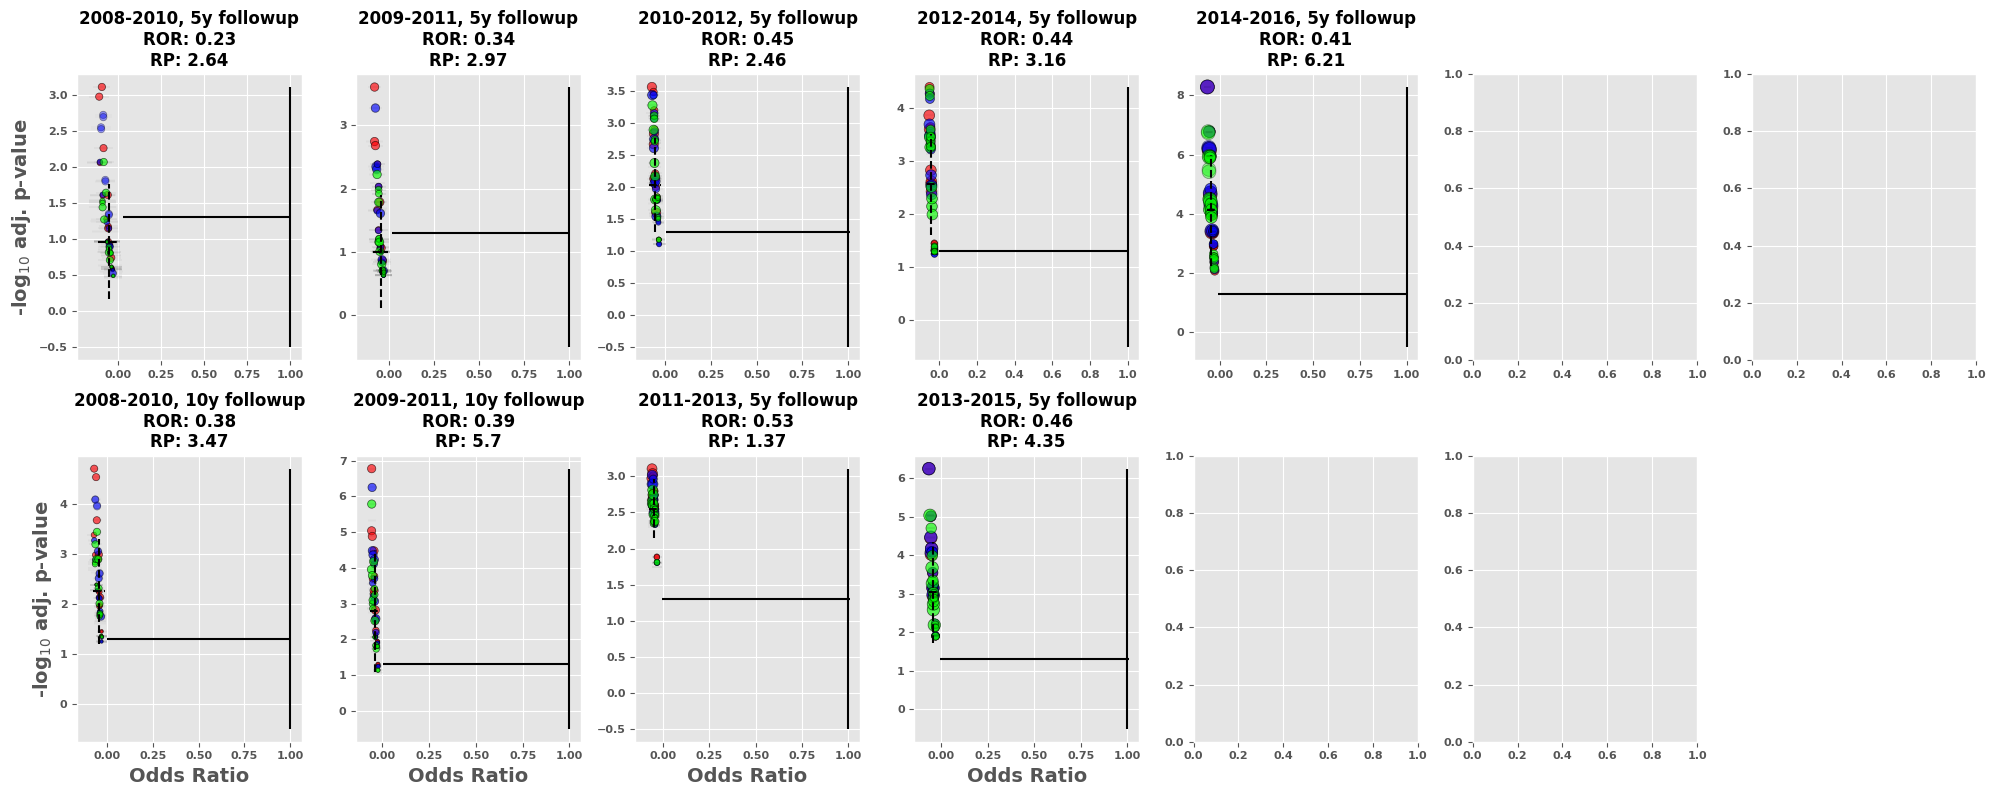

In [57]:
#plot and color based on follow-up time and controlling for SUD
plt.style.use('default')
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 8
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = 'bold'
cmap = sns.color_palette("icefire", as_cmap=True)

#Five plots:
#2006-2009, 5y/10y followup
#2009-2012, 5y/10y followup
#2012-2015, 5y followup

#2 rows, 3 columns of plots
f, ax = plt.subplots(nrows=2, ncols=7, figsize=(20,8))
f.delaxes(ax[1,6])

#min-max scale marker size based on total N of experiments for plotting and legend
markermin = 5
markermax = 100
res = allexpts
res['markerscale'] = (markermax-markermin) * ((res['total_N'] - min(res['total_N'])) / \
                                               (max(res['total_N']) - min(res['total_N']))) + markermin
alpha=0.4
edgecolor='black'
p_col = 'bh_p'
   
#subset data for each plot
ds_plot = []
ax_row = 0
ax_col = 0
for ey in [2008,2009,2010,2011,2012,2013,2014]:
    for fut in [5,10]:
        if ey>2009 and fut==10:
            continue
        ds = res[(res.start_enroll==ey) & (res.followup_time==fut) \
                # & (res.hx_depression==0) & (res.hx_anxiety==0)
                ]
                 #(res.opioid_rx_enroll>10)]
        
        ds_plot.append((ds,(ax_row,ax_col),fut))
        
        if ax_row==0:
            ax_row+=1
        else:
            ax_col+=1
            ax_row=0
        
plotby='controls'
for i,ds in enumerate(ds_plot):
#     print(np.mean(ds[0].total_N))
    plot_results(ds[0], ds[1], ds[2], plotby=plotby)

plt.tight_layout()
# plt.savefig('../figures/binaryNCDOutcome_binaryOpioidExposure_sameScale.png', dpi=300)

In [60]:
#AGE OF ONSET
def plot_results(r, panel, fu, plotby='controls'):
    
    #solid lines denoting increased/decreased odds and statistical significance
    ax[panel].hlines(-np.log10(0.05),xmin=0-(0.25*max(r.coef)),#0.5,#
                     xmax=max(r['.975']),#8,#
                     color='black')
    ax[panel].vlines(0, ymin=-0.5, ymax=-np.log10(min(r[p_col])),#34,#
                     color='black')

    #vertical dotted line showing median coef
    range_pvals = (max(-np.log10(r[p_col])) - min(-np.log10(r[p_col])))
    ax[panel].vlines(np.median(r.coef), ymin=\
                     np.median(-np.log10(r[p_col]))-(0.3*range_pvals), #np.median(-np.log10(r[p_col]))-7,#
               ymax=\
                     np.median(-np.log10(r[p_col]))+(0.3*range_pvals), #np.median(-np.log10(r[p_col]))+7,#
                     linestyles='dashed', color='k')
    
    #horizontal dotted line showing median p-value  
    range_coefs = (max(r['.975']) - min(r['.025']))
    ax[panel].hlines(np.median(-np.log10(r[p_col])), xmin=\
                     np.median(r.coef)-(0.3*range_coefs), #np.median(r.coef)-2,#
               xmax=\
                     np.median(r.coef)+(0.3*range_coefs), #np.median(r.coef)+2,#
                     linestyles='dashed', color='k')    

#     ax[panel].set_xlim((0,8.5))
#     ax[panel].set_ylim((-1,35))
    
    #print median coef, median p, mean control age, mean opioid age
#     print(f'50% coef: {np.median(r.coef)}')
#     print(f'50% p: {np.median(r.bh_p)}')
#     print(f'mean control age: {np.mean(r.control_AgeMean)}')
#     print(f'mean opioid age: {np.mean(r.opioid_AgeMean)}')
#     print('\n')

    if plotby=='controls':
        p1=plot_by_controls(r,panel)
    elif plotby=='opioid_rx_enroll':
        p1=plot_by_opioid_rx_enroll(r,panel)
    
    #Axis labels
    if panel[1]==0:
        ax[panel].set_ylabel('-log$_{10}$ adj. p-value', fontsize=14)
    if panel[0]==1:
        ax[panel].set_xlabel('Odds Ratio', fontsize=14)
    
    #error bar start and stop points based on confidence interval of coef
    lower_error = abs(r.coef-r['.025'])
    higher_error = abs(r.coef-r['.975'])
    ax[panel].errorbar(r.coef, -np.log10(r[p_col]), xerr=[lower_error, higher_error],
                 alpha=0.2, color='k', linewidth=0.1, ls='none')
    
    #calculate relative odds ratio
    coefs = sorted(r.coef)
    rcoef = round(coefs[int(len(coefs)*.99)] / coefs[int(len(coefs)*.01)],2)
    #calculate relative p-value    
    ps = sorted(-np.log10(r.bh_p))
    rp = round(ps[int(len(ps)*.99)] - ps[int(len(ps)*.01)],2)
    
    #Title of plot with enrollment period, follow-up time, relative coef and relative p-value
    ax[panel].set_title(
        f"{r.start_enroll.values[0]}-{r.end_enroll.values[0]-1}, {fu}y followup\nROR: {rcoef}\nRP: {rp}",
            size=12)


/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Text(0.5, 0, 'Vibration number')

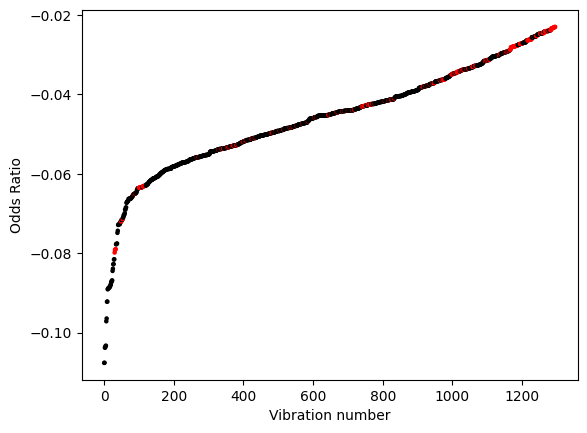

In [26]:
plt.style.use('default')
df['color'] = 'black'
df['color'].loc[df['bh_p'] >= 0.05] = 'red'
# df['color'].loc[(df['bh_p'] < 0.05) & (df['hx_hiv']==0) & (df['hx_sickle']==0)] = 'yellow'

df.sort_values(by='coef',inplace=True)

# plt.errorbar(range(len(df.coef)),df.coef, yerr=df['stderr'],alpha=0.02,color='grey')#'#E7E7E7')
plt.scatter(range(len(df.coef)),df.coef, color=df.color, s=5)
plt.ylabel('Odds Ratio')
plt.xlabel('Vibration number')